In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
i2s = {p+1:l for p, l in enumerate(chars)}
i2s[0] = '.'

s2i = {}

for i, l in i2s.items():
    s2i[l] = i

In [7]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch] 
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # train_words
Xdev, Ydev = build_dataset(words[n1:n2]) # dev_words
Xte, Yte = build_dataset(words[n2:]) # test_words


vocab_size = len(chars)


In [8]:
class Linear:  # TRANSFORMATION LAYER
  
  def __init__(self, fan_in, fan_out, bias=True):  # FAN IN IS AMOUNT OF INPUTS, FAN OUT AMOUNT OF OUTPUTS
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  # CREATES TENSOR OF INPUT x OUTPUT SIZE with normal distrib
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [     # THIS IS CREATING A LIST WHERE EACH TRANSFORM WILL HAPPEN::: WEIGHTS => BATCHNORM => TanH
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
#   layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46386


In [9]:
# same optimization as last time
max_steps = 5000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
      
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # CREATES RAND INTS OF "BATCH SIZE" FROM 0 => Training size
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:  # LOOP THE LAYERS AND PERFORM TRANSFORM
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        if i % 1000 == 0:
            print("training network")
#         print("Test Stage - Remove Break")
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/   5000: 3.2546


IndexError: Target 26 is out of bounds.

layer 1 (      Tanh): mean -0.03, std 0.63, saturated: 4.72%
layer 3 (      Tanh): mean +0.00, std 0.49, saturated: 0.19%
layer 5 (      Tanh): mean -0.01, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean -0.01, std 0.36, saturated: 0.00%
layer 9 (      Tanh): mean +0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

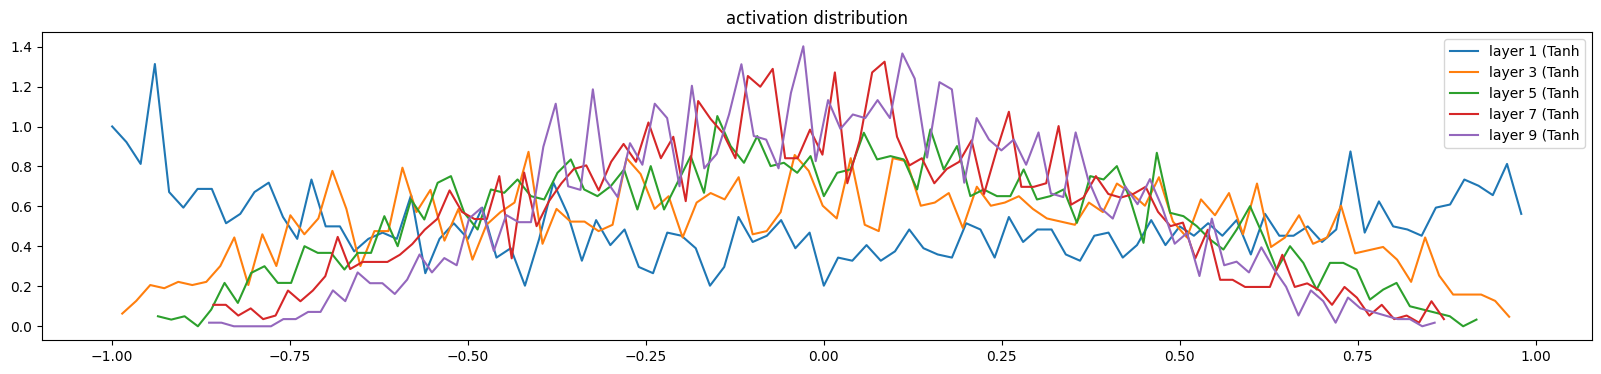

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

/var/folders/1f/_7z9t82101973t_1gxmf2vwc0000gn/T/ipykernel_75723/1958459093.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (26, 10) | mean -0.000019 | std 5.014036e-04 | grad:data ratio 4.891702e-04
weight  (30, 100) | mean -0.000003 | std 7.553120e-04 | grad:data ratio 4.118798e-03
weight (100, 100) | mean -0.000006 | std 7.114817e-04 | grad:data ratio 7.085285e-03
weight (100, 100) | mean -0.000006 | std 6.397133e-04 | grad:data ratio 6.412633e-03
weight (100, 100) | mean -0.000002 | std 5.944763e-04 | grad:data ratio 5.944747e-03
weight (100, 100) | mean +0.000002 | std 5.579214e-04 | grad:data ratio 5.564242e-03
weight  (100, 26) | mean -0.000000 | std 1.086093e-02 | grad:data ratio 1.067744e+00


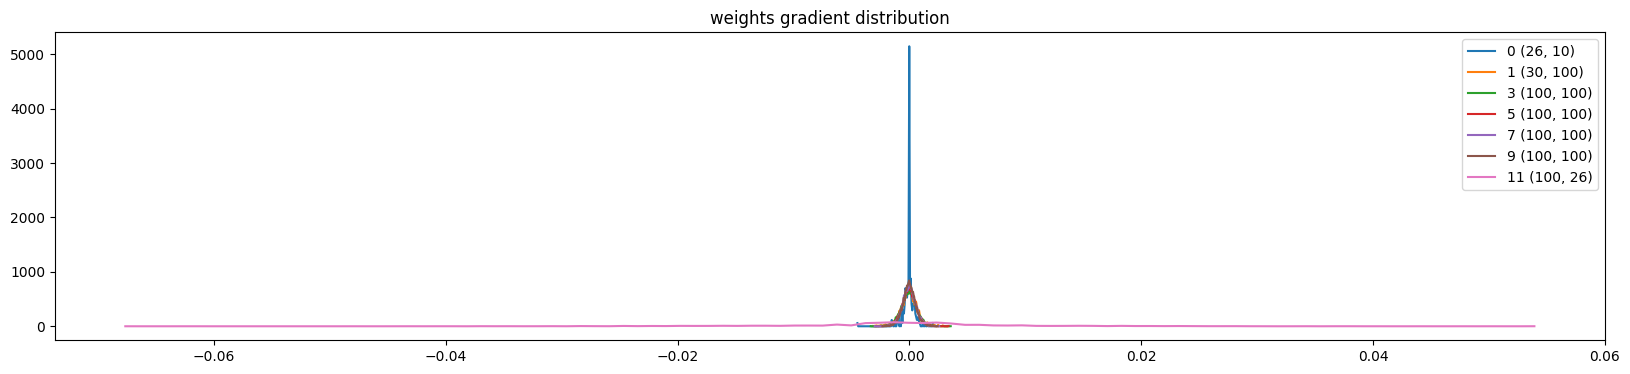

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

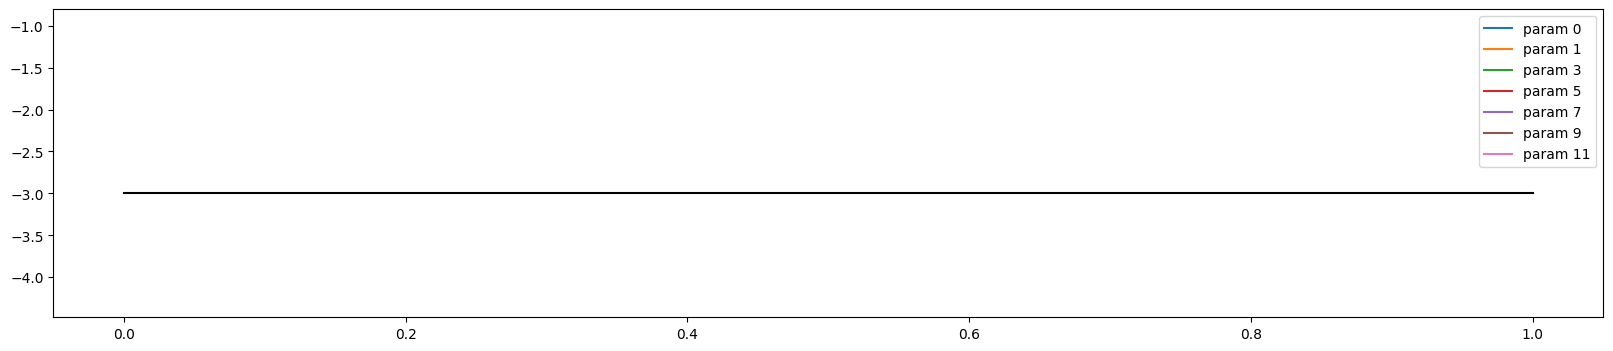

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [14]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(30):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
      # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
      # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

erbuagmyajhhgevvndhfyalwqetvrsjejdrljg.
oqcjedgeliihsmpqppalekeixvqnwxarqeptucmhvqrpcn.
shdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubfmgvdtrxyqqufmehg.
kmejqvskkydmihjl.
cakyybsufpubjglvjurenjcrtvwsvevoecmpfhdxrfqyxoeobhggptixjsfcueywhkhmreolviilqiiffwvpkxwvlla.
odtabfsbtjndgoikvsblitgfkxvbssivpu.
meewrkepxcmvyhxavttudkjgctekhgcgtipvtudt.
iwbdnihxvorlq.
cjakepxugniagcrpppfmiipxjgvonxet.
jydnblkskfporygnogsvmwosfdybsyknvmjcxtkncjbmu.
jtew.
aow.
copmrlxkkdcqbcep.
ccdfivsnipimhtecmokagouwtlrurdckappomtcokwxtnbndkdphfam.
xcojfffuncxkhosy.
sj.
ascnpc.
cilwtancuhrdtebimm.
ynw.
lu.
jaghwehtvggujbklwsofjiuox.
qufhraijjuuy.
t.
ccliussjafxvotxomeorie.
qqjkfdvawyofgqlmmuomvvnegbgdiyhtwt.
jwfvcgdv.
beejsxrsy.
nabhxtnxeardpqyjmxsi.
jkoletcfmsncovpepyckoajkdgvoyelrpfpayamrtkchqpjplbjttuqqcjteuesulsjivxawfahryefftolgdxltd.
